In [332]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import operator

In [333]:
def distance_between(p1, p2): 
	a = p2[0] - p1[0]
	b = p2[1] - p1[1]
	return np.sqrt((a ** 2) + (b ** 2))


In [334]:
def plot_many_images(images, rows= 9, columns= 9):
    for i, image in enumerate(images): 
        plt.subplot(rows, columns, i+1)
        plt.imshow(image, 'gray')
    # 		plt.title(titles[i])
        plt.xticks([]), plt.yticks([])   
    plt.show()

In [335]:
def show_image(img, title = 'masaow'):
    cv2.namedWindow(title,cv2.WINDOW_NORMAL)
    cv2.resizeWindow(title, 600,600)
#     plt.imshow(img)
    cv2.imshow(title, img)
    cv2.waitKey(0) 
    cv2.destroyAllWindows() 

In [336]:
def display_points(in_img, points, radius=5, colour=(0, 0, 255)):
	img = in_img.copy()
	if len(colour) == 3:
		if len(img.shape) == 2:
			img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
		elif img.shape[2] == 1:
			img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

	for point in points:
		img = cv2.circle(img, tuple(int(x) for x in point), radius, colour, -1)
	show_image(img)
	return img

In [337]:
def display_rects(img, rects, colour=(0, 0, 255)): 
# 	img = convert_when_colour(colour, in_img.copy())
    c = 0
    for rect in rects:
        c += 1
        img = cv2.rectangle(img, tuple(int(x) for x in rect[0]), tuple(int(x) for x in rect[1]), colour)
    print(c)
    show_image(img)

In [338]:
def show_digits(digits, colour=255):
	"""Shows list of 81 extracted digits in a grid format"""
	rows = []
	with_border = [cv2.copyMakeBorder(img.copy(), 1, 1, 1, 1, cv2.BORDER_CONSTANT, None, colour) for img in digits]
	for i in range(9):
		row = np.concatenate(with_border[i * 9:((i + 1) * 9)], axis=1)
		rows.append(row)
	show_image(np.concatenate(rows))

In [339]:
def convert_when_colour(colour, img):
    if len(colour) == 3:
        if len(img.shape) == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        elif img.shape[2] == 1:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    return img

function applying gaussian blurring, adaptive thresholding, inverting and dilating

In [340]:
def preprocess_image(img, skip_dilate=False):
	output = cv2.GaussianBlur(img.copy(), (9, 9), 0)
	output = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY, 11, 2)
	output = cv2.bitwise_not(output, output)

	if not skip_dilate:
		kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]], np.uint8)
		output = cv2.dilate(output, kernel)
	return output

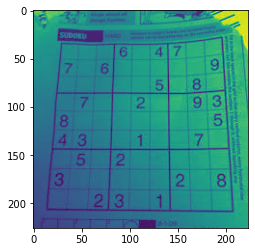

In [341]:
img = cv2.imread("samples\example4.jpg", cv2.IMREAD_GRAYSCALE)
plt.imshow(img)

In [342]:
adaptiveThresholding = preprocess_image(img, True)
print(img.ndim)
print(adaptiveThresholding.ndim)

2
2


In [343]:
def find_corners_and_show_contour():
    global adaptiveThresholding
    contours, h = cv2.findContours(adaptiveThresholding.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    adaptiveThresholding = cv2.cvtColor(adaptiveThresholding, cv2.COLOR_GRAY2RGB) 
    polygon = contours[0]
    ourGrid = cv2.drawContours(adaptiveThresholding.copy(), [polygon] , -1, (255,0,0), 2)
    show_image(ourGrid,'contour with largest area')
    
    bottom_right, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_left, _ = min(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    bottom_left, _ = min(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_right, _ = max(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    
    return [polygon[top_left][0], polygon[top_right][0], polygon[bottom_right][0], polygon[bottom_left][0]]


In [344]:
def display_points(in_img, points, radius=5, colour=(0, 0, 255)):
	img = in_img.copy()
	if len(colour) == 3:
		if len(img.shape) == 2:
			img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
		elif img.shape[2] == 1:
			img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

	for point in points:
		img = cv2.circle(img, tuple(int(x) for x in point), radius, colour, -1)
	show_image(img, 'Look at grid')

Finding the corner points of the contour

In [345]:
corners = find_corners_and_show_contour()

In [346]:
display_points(adaptiveThresholding, corners)

In [347]:
def crop_and_warp(img, crop_rect):

	top_left, top_right, bottom_right, bottom_left = crop_rect[0], crop_rect[1], crop_rect[2], crop_rect[3]

	src = np.array([top_left, top_right, bottom_right, bottom_left], dtype='float32')
 
	side = max([
		distance_between(bottom_right, top_right),
		distance_between(top_left, bottom_left),
		distance_between(bottom_right, bottom_left),
		distance_between(top_left, top_right)
	])

	dst = np.array([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]], dtype='float32')
	m = cv2.getPerspectiveTransform(src, dst)
	return cv2.warpPerspective(img, m, (int(side), int(side)))

In [348]:
sudokuCropped = crop_and_warp(adaptiveThresholding, corners)

In [349]:
show_image(sudokuCropped, 'final Output')

In [350]:
def infer_grid(img): 
    squares = []
    side = img.shape[:1]
    side = side[0] / 9
    for j in range(9):
        for i in range(9):
            p1 = (i * side, j * side)  # Top left corner of a bounding box
            p2 = ((i + 1) * side, (j + 1) * side)  # Bottom right corner of bounding box
            squares.append((p1, p2))
    return squares

In [351]:
squares = infer_grid(sudokuCropped)

In [352]:
display_rects(sudokuCropped, squares)

81


In [353]:
def cut_from_rect(img, rect):
    return img[int(rect[0][1]):int(rect[1][1]), int(rect[0][0]):int(rect[1][0])]


In [354]:
def scale_and_centre(img, size, margin=0, background=0):
    h, w = img.shape[:2]
    def centre_pad(length): 
        if length % 2 == 0:
            side1 = int((size - length) / 2)
            side2 = side1
        else:
            side1 = int((size - length) / 2)
            side2 = side1 + 1
        return side1, side2

    def scale(r, x):
        return int(r * x)

    if h > w:
        t_pad = int(margin / 2)
        b_pad = t_pad
        ratio = (size - margin) / h
        w, h = scale(ratio, w), scale(ratio, h)
        l_pad, r_pad = centre_pad(w)
    else:
        l_pad = int(margin / 2)
        r_pad = l_pad
        ratio = (size - margin) / w
        w, h = scale(ratio, w), scale(ratio, h)
        t_pad, b_pad = centre_pad(h)

    img = cv2.resize(img, (w, h))
    img = cv2.copyMakeBorder(img, t_pad, b_pad, l_pad, r_pad, cv2.BORDER_CONSTANT, None, background)
    return cv2.resize(img, (size, size))

In [355]:
def find_largest_feature(inp_img, scan_tl=None, scan_br=None):
	"""
	Uses the fact the `floodFill` function returns a bounding box of the area it filled to find the biggest
	connected pixel structure in the image. Fills this structure in white, reducing the rest to black.
	"""
	img = inp_img.copy()  # Copy the image, leaving the original untouched
	height, width = img.shape[:2]

	max_area = 0
	seed_point = (None, None)

	if scan_tl is None:
		scan_tl = [0, 0]

	if scan_br is None:
		scan_br = [width, height]

	# Loop through the image
	for x in range(scan_tl[0], scan_br[0]):
		for y in range(scan_tl[1], scan_br[1]):
			# Only operate on light or white squares
			if img.item(y, x) == 255 and x < width and y < height:  # Note that .item() appears to take input as y, x
				area = cv2.floodFill(img, None, (x, y), 64)
				if area[0] > max_area:  # Gets the maximum bound area which should be the grid
					max_area = area[0]
					seed_point = (x, y)

	# Colour everything grey (compensates for features outside of our middle scanning range
	for x in range(width):
		for y in range(height):
			if img.item(y, x) == 255 and x < width and y < height:
				cv2.floodFill(img, None, (x, y), 64)

	mask = np.zeros((height + 2, width + 2), np.uint8)  # Mask that is 2 pixels bigger than the image

	# Highlight the main feature
	if all([p is not None for p in seed_point]):
		cv2.floodFill(img, mask, seed_point, 255)

	top, bottom, left, right = height, 0, width, 0

	for x in range(width):
		for y in range(height):
			if img.item(y, x) == 64:  # Hide anything that isn't the main feature
				cv2.floodFill(img, mask, (x, y), 0)

			# Find the bounding parameters
			if img.item(y, x) == 255:
				top = y if y < top else top
				bottom = y if y > bottom else bottom
				left = x if x < left else left
				right = x if x > right else right

	bbox = [[left, top], [right, bottom]]
	return img, np.array(bbox, dtype='float32'), seed_point

In [356]:
def extract_digit(img, rect, size):
    digit = cut_from_rect(img, rect) 
    h, w = digit.shape[:2]
    margin = int(np.mean([h, w]) / 2.5)
    _, bbox, seed = find_largest_feature(digit, [margin, margin], [w - margin, h - margin])
    digit = cut_from_rect(digit, bbox)

    w = bbox[1][0] - bbox[0][0]
    h = bbox[1][1] - bbox[0][1] 
    
    if w > 0 and h > 0 and (w * h) > 100 and len(digit) > 0:
        return scale_and_centre(digit, size, 4)
    else:
        return np.zeros((size, size), np.uint8)

In [357]:
def get_digits(img, squares, size): 
	digits = [] 
	for square in squares:
		digits.append(extract_digit(img, square, size))
	return digits

In [358]:
sudokuCropped = cv2.cvtColor(sudokuCropped, cv2.COLOR_BGR2GRAY)
digits = get_digits(sudokuCropped, squares, 28) 

In [359]:
show_digits(digits)
digits = np.array(digits)

In [360]:
# data = 'string or data-table to pass'
%store digits
# del digits

Stored 'digits' (ndarray)
